In [1]:
# ==============================================================================
# 0. SZEKCIÓ: KÖRNYEZET BEÁLLÍTÁSA ÉS CSOMAGOK BETÖLTÉSE
# ==============================================================================
# Szükséges csomagok telepítése (ha még nem történt meg)
# install.packages(c("bsvars", "ggplot2", "dplyr", "tidyr", "lubridate", "rhdf5", "patchwork", "ggdist"))

install.packages('bsvars', repos = c('https://bsvars.r-universe.dev', 'https://cloud.r-project.org'))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTN’, ‘GIGrvg’, ‘stochvol’




In [2]:
# Csomagok betöltése
library(bsvars)
library(ggplot2)
library(dplyr)
library(tidyr)
library(lubridate)
library(rhdf5)
library(patchwork)
library(ggdist) # Az elegáns fanchartokhoz

# Vizuális beállítások
theme_set(theme_bw() + theme(plot.title = element_text(hjust = 0.5)))

# Kimeneti mappa
output_dir <- "eredmenyek_bsvars"
if (!dir.exists(output_dir)) {
  dir.create(output_dir)
}
cat(sprintf("Minden kimenet a '%s/' mappába lesz mentve.\n", output_dir))


# ==============================================================================
# 1. SZEKCIÓ: ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE
# ==============================================================================
cat("\n--- 1. Adatok betöltése és előkészítése ---\n")

data_path <- "/kaggle/input/download-etf-macro-data-in-python/financial_factors.csv.gz"
meta_path <- "/kaggle/input/download-etf-macro-data-in-python/financial_factors_meta.csv.gz"

etf_meta_df <- read.csv(meta_path)
all_factors_df <- read.csv(data_path, row.names = "Date")
all_factors_df$Date <- ymd(rownames(all_factors_df))

asset_symbols <- etf_meta_df %>%
  filter(type == 'asset_return' | asset_class == 'MACRO') %>%
  pull(symbol) |> gsub("\\^", "X.", x = _)
hist_returns <- all_factors_df[, c(asset_symbols, "Date")]

Y <- as.matrix(hist_returns[, asset_symbols])
T_ <- nrow(Y)
D <- ncol(Y)
cat(sprintf("A modell bemeneti mátrixának (Y) mérete: %d időpont, %d eszköz.\n", T_, D))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Minden kimenet a 'eredmenyek_bsvars/' mappába lesz mentve.

--- 1. Adatok betöltése és előkészítése ---
A modell bemeneti mátrixának (Y) mérete: 220 időpont, 14 eszköz.



--- 2. BVAR-SV modell becslése ---
BVAR-SV modell becslése... (ez eltarthat egy ideig)


The identification is set to the default option of lower-triangular structural matrix.



**************************************************|
bsvars: Bayesian Structural Vector Autoregressions|
**************************************************|
 Gibbs sampler for the SVAR-SV model              |
   Non-centred SV model is estimated              |
**************************************************|
 Progress of the MCMC simulation for 2500 draws
    Every draw is saved via MCMC thinning
 Press Esc to interrupt the computations
**************************************************|
**************************************************|
bsvars: Bayesian Structural Vector Autoregressions|
**************************************************|
 Gibbs sampler for the SVAR-SV model              |
   Non-centred SV model is estimated              |
**************************************************|
 Progress of the MCMC simulation for 5000 draws
    Every draw is saved via MCMC thinning
 Press Esc to interrupt the computations
**************************************************|
A modell b

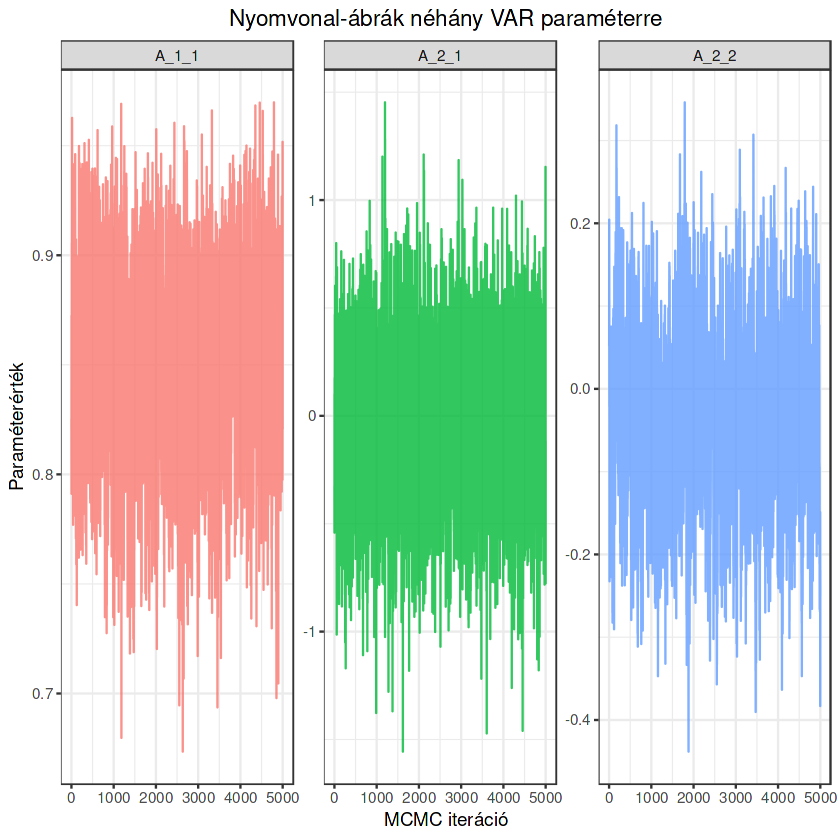

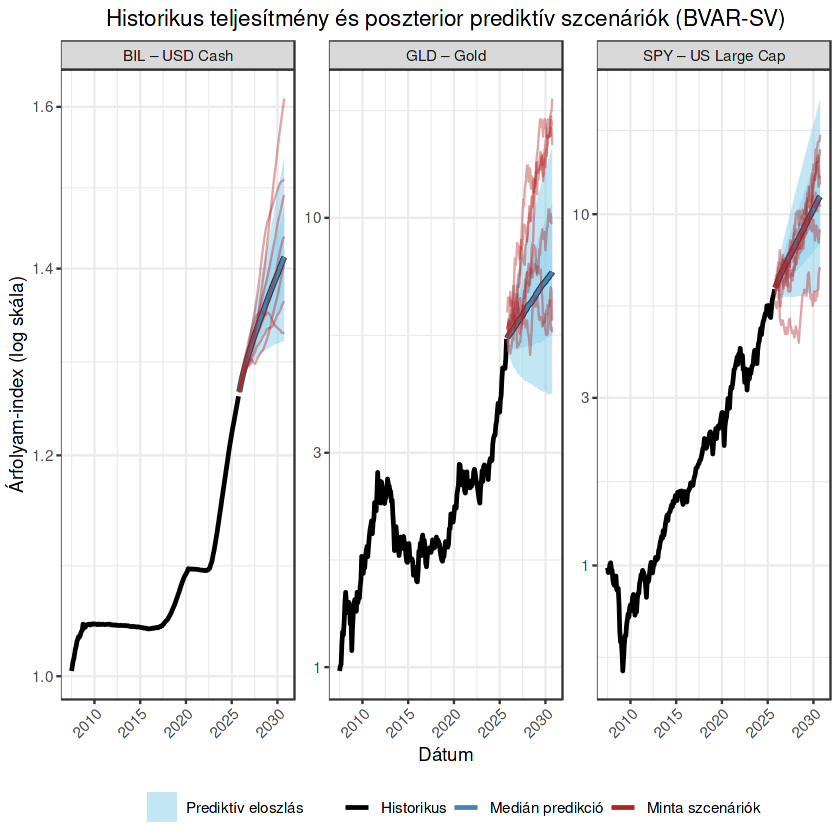

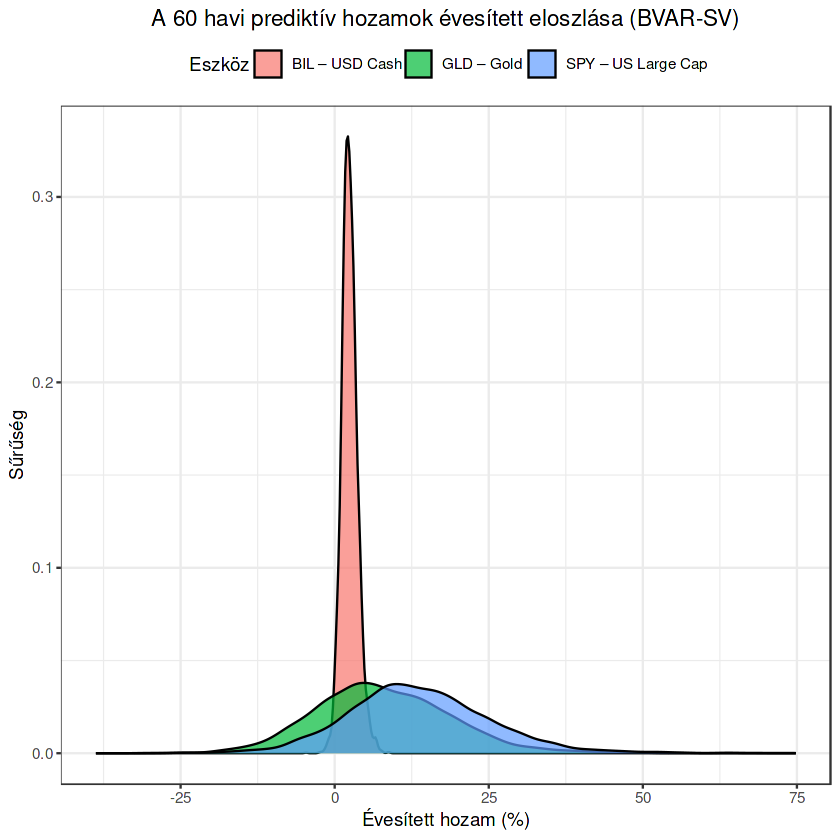


--- 6. Eredmények mentése ---


[1] TRUE

You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.



A PPC szcenáriók elmentve HDF5 formátumban: eredmenyek_bsvars/ppc_scenarios_bsvars.h5
A teljes modell objektum (posterior) elmentve.

A `bsvars` munkafolyamat sikeresen lezárult.


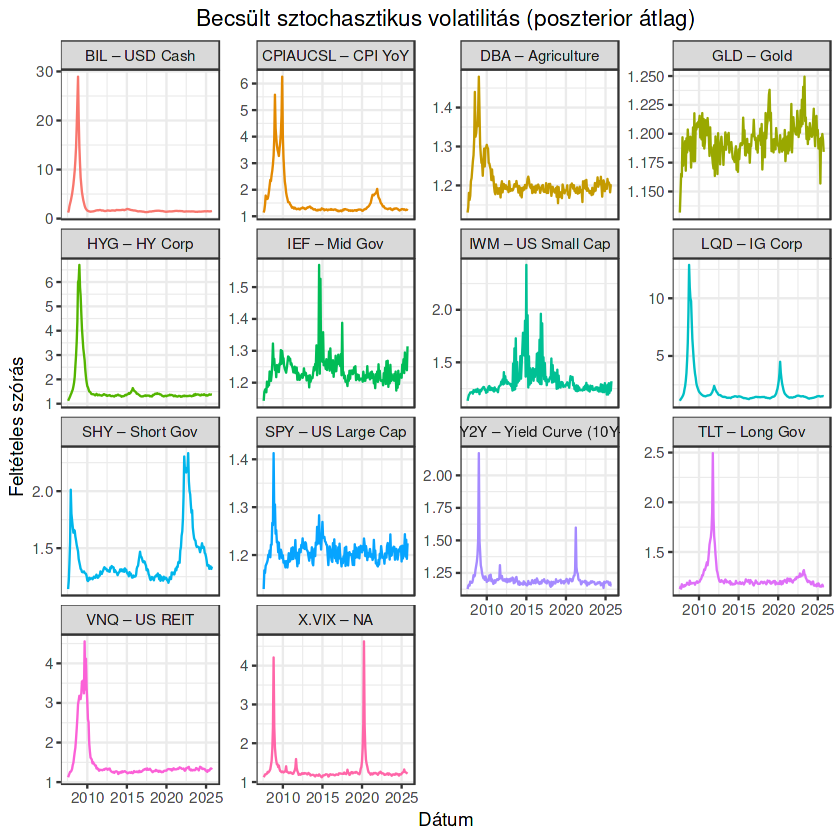

In [3]:
# ==============================================================================
# 2. SZEKCIÓ: BVAR-SV MODELL BECSLÉSE
# ==============================================================================
cat("\n--- 2. BVAR-SV modell becslése ---\n")

set.seed(123)
start_time <- Sys.time()
cat("BVAR-SV modell becslése... (ez eltarthat egy ideig)\n")

specification <- specify_bsvar_sv$new(data = Y, p = 1)
burn_in <- estimate(specification, S = 2500, show_progress = TRUE)
posterior <- estimate(burn_in, S = 5000, show_progress = TRUE)

end_time <- Sys.time()
cat(sprintf("A modell becslése %.1f perc alatt befejeződött.\n", as.numeric(end_time - start_time, units = "mins")))


# ==============================================================================
# 3. SZEKCIÓ: POSZTERIOR DIAGNOSZTIKA
# ==============================================================================
cat("\n--- 3. Poszterior diagnosztika ---\n")

summary_fit <- summary(posterior)
print(summary_fit)

n_samples <- dim(posterior$posterior$A)[3]
trace_data <- data.frame(
  Iteration = 1:n_samples,
  A_1_1 = posterior$posterior$A[1, 1, ], # BIL hatása saját magára
  A_2_1 = posterior$posterior$A[2, 1, ], # BIL hatása SPY-ra
  A_2_2 = posterior$posterior$A[2, 2, ]  # SPY hatása saját magára
) %>%
  pivot_longer(-Iteration, names_to = "Parameter", values_to = "Value")

p_trace <- ggplot(trace_data, aes(x = Iteration, y = Value, color = Parameter)) +
  geom_line(alpha = 0.8) +
  facet_wrap(~Parameter, scales = "free_y") +
  labs(title = "Nyomvonal-ábrák néhány VAR paraméterre", x = "MCMC iteráció", y = "Paraméterérték") +
  theme(legend.position = "none")

print(p_trace)
ggsave(file.path(output_dir, "diag_bsvars_trace.png"), p_trace, width = 10, height = 4)


# ==============================================================================
# 4. SZEKCIÓ: POSZTERIOR PREDIKTÍV SZIMULÁCIÓK (PPC)
# ==============================================================================
cat("\n--- 4. Poszterior prediktív szimulációk (PPC) ---\n")
n_steps <- 60
ppc_results <- forecast(posterior, horizon = n_steps)
# Dimenziók: (eszköz, lépés, szcenárió)
ppc_scenarios <- ppc_results$forecasts
cat(sprintf("Sikeresen generáltunk %d lépéses szcenáriót.\n", n_steps))
cat(sprintf("A szcenárió tömb mérete: %s\n", paste(dim(ppc_scenarios), collapse = " x ")))


# ==============================================================================
# 5. SZEKCIÓ: VIZUALIZÁCIÓ ÉS EREDMÉNYEK ÉRTELMEZÉSE (JAVÍTOTT)
# ==============================================================================
cat("\n--- 5. Vizualizáció és eredmények értelmezése ---\n")

name_map <- setNames(etf_meta_df$name, etf_meta_df$symbol)
label_for <- function(ticker) sprintf("%s – %s", ticker, name_map[ticker])
assets_to_plot <- c("BIL", "SPY", "GLD")

# 5.1. Ábra: Kombinált historikus és PPC "fanchart" (ggdist-tel)
# -----------------------------------------------------------------------
cat("Fanchart ábra készítése ggdist segítségével...\n")
last_hist_date <- tail(hist_returns$Date, 1)
future_dates <- seq(from = last_hist_date, by = "month", length.out = n_steps + 1)[-1]
n_trajectories_to_plot <- 7

# Historikus adatok előkészítése
hist_cum_df <- hist_returns %>%
  select(all_of(c(assets_to_plot, "Date"))) %>%
  pivot_longer(-Date, names_to = "Asset", values_to = "Return") %>%
  group_by(Asset) %>%
  mutate(Cumulative = cumprod(1 + Return))

# PPC adatok előkészítése "tidy" formátumba a ggdist számára
dimnames(ppc_scenarios) <- list(Asset = colnames(Y), Step = 1:n_steps, Draw = 1:n_samples)
ppc_long_df <- as.data.frame.table(ppc_scenarios, responseName = "Return") %>%
  mutate(Step = as.integer(Step)) %>%
  filter(Asset %in% assets_to_plot)

# Kumulált hozamok számítása minden egyes szcenárióra
last_cum_values <- hist_cum_df %>% group_by(Asset) %>% summarise(LastCum = last(Cumulative), .groups = 'drop')
ppc_cum_df <- ppc_long_df %>%
  group_by(Asset, Draw) %>%
  arrange(Step) %>%
  mutate(CumulativeReturn = cumprod(1 + Return)) %>%
  ungroup() %>%
  left_join(last_cum_values, by = "Asset") %>%
  mutate(CumulativeValue = CumulativeReturn * LastCum,
         Date = future_dates[Step])

# Az ábra összeállítása `stat_lineribbon`-nal
p_fanchart <- ggplot(ppc_cum_df, aes(x = Date, y = CumulativeValue)) +
  # Historikus adatok
  geom_line(data = hist_cum_df, aes(y = Cumulative, color = "Historikus"), linewidth = 1) +
  # ggdist lineribbon a bizonytalansági sávokhoz
  stat_lineribbon(aes(fill = "Prediktív eloszlás"), .width = c(.5, .8), alpha = 0.5) +
  # Medián predikció vonala
  stat_summary(fun = median, geom = "line", aes(color = "Medián predikció"), linewidth = 0.8) +
  # Néhány minta trajektória
  geom_line(data = filter(ppc_cum_df, Draw %in% 1:n_trajectories_to_plot),
            aes(group = Draw, color = "Minta szcenáriók"), linewidth = 0.5, alpha = 0.4) +
  # Facet-ek és skálák
  facet_wrap(~Asset, scales = "free_y", labeller = as_labeller(label_for)) +
  scale_y_log10() +
  scale_color_manual(name = "", values = c("Historikus" = "black", "Minta szcenáriók" = "firebrick", "Medián predikció" = "steelblue")) +
  scale_fill_manual(name = "", values = c("Prediktív eloszlás" = "skyblue")) +
  guides(color = guide_legend(override.aes = list(linewidth = 1, alpha=1))) +
  labs(title = "Historikus teljesítmény és poszterior prediktív szcenáriók (BVAR-SV)", x = "Dátum", y = "Árfolyam-index (log skála)") +
  theme(legend.position = "bottom", axis.text.x = element_text(angle = 45, hjust = 1))

print(p_fanchart)
ggsave(file.path(output_dir, "viz_bsvars_fanchart_ggdist.png"), p_fanchart, width = 12, height = 6)

# 5.2. Ábra: Évesített PPC hozamok eloszlása (JAVÍTOTT)
# ---------------------------------------------------------
# JAVÍTÁS: Az `apply` helyes margója c(1, 3), hogy az eszközökön és szcenáriókon
# iteráljon, és a függvényt a lépések (dim 2) mentén alkalmazza.
annualized_returns_matrix <- apply(ppc_scenarios, c(1, 3), function(x) {
    (prod(1 + x))^(12 / n_steps) - 1
  }) # Ennek eredménye egy (eszköz x szcenárió) mátrix

# A mátrixot most már helyesen tudjuk data frame-mé alakítani és pivotálni
annualized_returns_df <- as.data.frame(t(annualized_returns_matrix)) %>% # Transzponálás, hogy az oszlopok az eszközök legyenek
  `colnames<-`(colnames(Y)) %>%
  pivot_longer(everything(), names_to = "Asset", values_to = "AnnualizedReturn") %>%
  filter(Asset %in% assets_to_plot)

p_density <- ggplot(annualized_returns_df, aes(x = AnnualizedReturn * 100, fill = Asset)) +
  geom_density(alpha = 0.7) +
  scale_fill_discrete(name = "Eszköz", labels = sapply(assets_to_plot, label_for)) +
  labs(
    title = sprintf("A %d havi prediktív hozamok évesített eloszlása (BVAR-SV)", n_steps),
    x = "Évesített hozam (%)", y = "Sűrűség"
  ) +
  theme(legend.position = "top")

print(p_density)
ggsave(file.path(output_dir, "viz_bsvars_annualized_dist.png"), p_density, width = 10, height = 5)

# 5.3. Ábra: Időben változó volatilitás (JAVÍTOTT)
# ---------------------------------------------------------
# JAVÍTÁS: Robusztus, direkt adat-előkészítés a vizualizációhoz

# 1. Lépés: Kiszámoljuk a poszterior átlag volatilitást
mean_volatility_matrix <- apply(exp(posterior$posterior$h / 2), c(1, 2), mean)

# 2. Lépés: A mátrixot egyből "hosszú" formátumú data frame-mé alakítjuk
# Ezzel kikerüljük a problémás köztes lépéseket
volatility_df_final <- as.data.frame(t(mean_volatility_matrix)) %>%
  setNames(colnames(Y)) %>% # Oszlopnevek beállítása
  mutate(Date = tail(hist_returns$Date, -1)) %>% # Dátum oszlop hozzáadása (T-1 hosszú most, mert p=1)
  pivot_longer(
    cols = -Date,
    names_to = "Asset",
    values_to = "Volatility"
  )

# 3. Lépés: Az ábra létrehozása a végleges, tiszta data frame-ből
p_volatility <- ggplot(volatility_df_final, aes(x = Date, y = Volatility)) +
  geom_line(aes(color = Asset)) +
  facet_wrap(~Asset, scales = "free_y", labeller = as_labeller(label_for)) +
  labs(
    title = "Becsült sztochasztikus volatilitás (poszterior átlag)",
    x = "Dátum", y = "Feltételes szórás", color = "Eszköz"
  ) +
  theme(legend.position = "none")

print(p_volatility)
ggsave(file.path(output_dir, "viz_bsvars_volatility.png"), p_volatility, width = 10, height = 5)

# ==============================================================================
# 6. SZEKCIÓ: EREDMÉNYEK MENTÉSE
# ==============================================================================
cat("\n--- 6. Eredmények mentése ---\n")

h5_path <- file.path(output_dir, "ppc_scenarios_bsvars.h5")
if(file.exists(h5_path)) file.remove(h5_path)
h5createFile(h5_path)
h5write(ppc_scenarios, h5_path, "scenarios")
cat(sprintf("A PPC szcenáriók elmentve HDF5 formátumban: %s\n", h5_path))

saveRDS(posterior, file.path(output_dir, "fit_bsvars_posterior.rds"))
cat("A teljes modell objektum (posterior) elmentve.\n")

cat("\nA `bsvars` munkafolyamat sikeresen lezárult.\n")

In [4]:
macro_symbols <- etf_meta_df %>%
  filter(asset_class == "MACRO") %>%
  pull(symbol) |> gsub("\\^", "X.", x = _)
#macro_symbols
#all_factors_df |> glimpse()
hist_macro <- all_factors_df[, c(macro_symbols, "Date")]
hist_macro |> glimpse()

Rows: 220
Columns: 4
$ X.VIX    <dbl> 14.94762, 17.27333, 25.02609, 22.19895, 19.11565, 25.58238, 2…
$ T10Y2Y   <dbl> -0.02, 0.22, 0.39, 0.39, 0.54, 0.93, 0.99, 1.50, 1.88, 1.83, …
$ CPIAUCSL <dbl> 2.7098857, 2.3178906, 1.8974485, 1.8974485, 3.6106984, 4.3732…
$ Date     <date> 2007-06-30, 2007-07-31, 2007-08-31, 2007-09-30, 2007-10-31, …
